In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import soundfile as sf
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background


In [10]:
Ttot = 1
Nbins = 1024
winShift = Nbins // 2
winType = 'rect'
winType = 'rootHann'


# Get signals
x, fs = sf.read('./signals/speechtrunc.wav')
x = x[:int(Ttot * fs)]
wTD, _ = sf.read('./signals/rir1.wav')
wTD = wTD[:Nbins] / np.amax(wTD) * .25

w = np.fft.fft(wTD, Nbins, axis=0)

In [11]:
if winType == 'rect':
    win = np.sqrt(winShift / Nbins) * np.ones(Nbins)
elif winType == 'rootHann':
    win = np.sqrt(2 * winShift / Nbins) * np.sqrt(np.hanning(Nbins))

# Compute WOLA
numChunks = len(x) // winShift
y_wola = np.zeros_like(x)
normVal = np.zeros_like(x)
for ii in range(numChunks):
    idxBeg = ii * winShift
    idxEnd = idxBeg + Nbins
    if idxEnd > len(x):
        break

    normVal[idxBeg:idxEnd] += win ** 2
    normVal[normVal < 1e-10] = 1  # don't normalize by small values

    Xcurr = np.fft.fft(x[idxBeg:idxEnd] * win, Nbins, axis=0)
    Ycurr = Xcurr * w
    ycurr = np.fft.ifft(Ycurr, Nbins, axis=0)
    ycurr = np.real_if_close(ycurr)

    # OLA
    y_wola[idxBeg:idxEnd] += ycurr * win
    # Normalize
    y_wola[idxBeg:idxBeg + winShift] /= normVal[idxBeg:idxBeg + winShift]


In [13]:
# Compute T(z) approximation
wTD_recomputed = np.fft.ifft(w, Nbins, axis=0)
H = la.circulant(np.flip(np.real_if_close(wTD_recomputed)))
A = np.diag(win) @ H @ np.diag(win)
ir_Tz = np.zeros(2 * Nbins - 1)
for ii in np.arange(start=-Nbins+1, stop=Nbins):
    ir_Tz[ii + Nbins - 1] = np.sum(np.diagonal(A, ii))

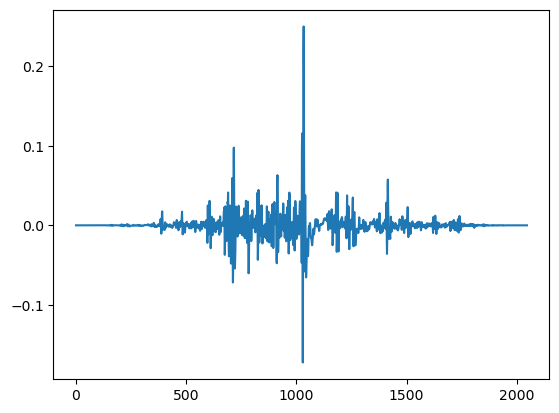

In [15]:
plt.plot(ir_Tz / winShift)